In [55]:
import numpy as np
import tensorrt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Create test model

In [167]:
class MaskModel(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.conv1 = layers.Conv1D(32, 2, activation='relu')
    self.flatten = layers.Flatten()
    self.d1 = layers.Dense(12, activation='relu')
    self.d2 = layers.Dense(2500)

    # self.loss_mse = tf.keras.losses.MeanSquaredError()
    # self.loss_masked_mse= masked_MeanSquaredError
    # self.optimizer = tf.keras.optimizers.SGD()
    # self.train_loss = tf.keras.metrics.Mean(name='train_loss')
    # self.train_accuracy = tf.keras.metrics.MeanSquaredError(name='train_accuracy')

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    x = self.d2(x)
    return tf.reshape(x, (-1,50,50))
  
  def train_step(self, data):
    x, y, masks = data
    sample_weight = None

    with tf.GradientTape() as tape:
      # training=True is only needed if there are layers with different
      # behavior during training versus inference (e.g. Dropout).
      y_pred = self(x, training=True)
      loss = self.loss(y, y_pred)
      # loss = self.compiled_loss(y, y_pred,regularization_losses=self.losses)
    self._validate_target_and_loss(y, loss)
    self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    # gradients = tape.gradient(loss, self.trainable_variables)
    # self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    for m in self.metrics:
      print(m.name)

    # # Update metrics (includes the metric that tracks the loss)
    # for metric in self.compiled_metrics._metrics:
    #     if metric.name == "loss":
    #         metric.update_state(loss)
    #     else:
    #         metric.update_state(y, y_pred)
    # # Return a dict mapping metric names to current value
    # # self.compiled_metrics.update_state(y_true=y, y_pred=y_pred, sample_weight=None)
    # return {m.name: m.result() for m in self.compiled_metrics._metrics} #self.get_metrics_result() # 
  
    return self.compute_metrics(x, y, y_pred, sample_weight)


In [168]:
# Create an instance of the model
from basenji import metrics

def masked_MeanSquaredError(y_true, y_pred):
  return tf.keras.losses.mean_squared_error(y_true, y_pred)

model = MaskModel()
model_metrics = [metrics.PearsonR(50), metrics.R2(50)]
model.compile(loss=masked_MeanSquaredError, optimizer="adam", metrics=model_metrics)

In [169]:
print(model.metrics)

[]


# Read Data

In [170]:
def file_to_records(filename):
  return tf.data.TFRecordDataset(filename, compression_type='ZLIB')

In [171]:
# seq_depth = 4 here, as four nucleotides, num_targets indicates number of values you want to predict for each pixel
def parse_proto(example_protos, seq_length=250, seq_depth=4, target_length=50, num_targets=50):
      """Parse TFRecord protobuf."""

      # define features
      features = {
        'sequence': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string)
      }

      # parse example into features
      parsed_features = tf.io.parse_single_example(example_protos, features=features)

      # decode sequence
      sequence = tf.io.decode_raw(parsed_features['sequence'], tf.uint8)
      sequence = tf.reshape(sequence, [seq_length, seq_depth])
    #     if self.seq_length_crop is not None:
    #       crop_len = (self.seq_length - self.seq_length_crop) // 2
    #       sequence = sequence[crop_len:-crop_len,:]
      sequence = tf.cast(sequence, tf.float32)
        
      # decode targets
      targets = tf.io.decode_raw(parsed_features['target'], tf.float16)
      targets = tf.reshape(targets, [target_length, num_targets])
      targets = tf.cast(targets, tf.float32)

      #decode mask
      mask = tf.io.decode_raw(parsed_features['mask'], tf.float16)
      mask = tf.reshape(mask, [target_length, num_targets])
      mask = tf.cast(mask, tf.float32)

      return sequence, targets, mask


In [172]:
tfr_path = '/home1/yxiao977/sc1/akita_dinoflagellate/squares_train_test_mask/*'

In [173]:
import glob
from natsort import natsorted
tfr_files = natsorted(glob.glob(tfr_path))
dataset = tf.data.Dataset.from_tensor_slices(tfr_files)

# repeat, so iteration on the dataset can be infinite untill you call stop
# dataset = dataset.repeat()

# interleave files
dataset = dataset.interleave(map_func=file_to_records,
    cycle_length=4,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

# shuffle
dataset = dataset.shuffle(buffer_size=128, reshuffle_each_iteration=True)

dataset = dataset.map(parse_proto) #self.rna_mode

# batch
dataset = dataset.batch(2)

# prefetch
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [174]:
class EarlyStoppingMin(tf.keras.callbacks.EarlyStopping):
  """Stop training when a monitored quantity has stopped improving.
  Arguments:
      min_epoch: Minimum number of epochs before considering stopping.
      
  """
  def __init__(self, min_epoch=0, **kwargs):
    super(EarlyStoppingMin, self).__init__(**kwargs)
    self.min_epoch = min_epoch

  def on_epoch_end(self, epoch, logs=None):
    current = self.get_monitor_value(logs)
    if current is None:
      return
    if self.monitor_op(current - self.min_delta, self.best):
      self.best = current
      self.wait = 0
      if self.restore_best_weights:
        self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
      if epoch >= self.min_epoch and self.wait >= self.patience:
        self.stopped_epoch = epoch
        self.model.stop_training = True
        if self.restore_best_weights:
          if self.verbose > 0:
            print('Restoring model weights from the end of the best epoch.')

tf.keras.utils.set_random_seed(9)
early_stop = EarlyStoppingMin(monitor='pearsonr', mode='max', verbose=1)
callbacks = [early_stop]
model_h = model.fit(dataset, epochs=15, callbacks=callbacks)


Epoch 1/15


pearsonr
r2
10/10 [==============================] - 1s 7ms/step - pearsonr: 0.1098 - r2: -0.3198
Epoch 2/15
10/10 [==============================] - 0s 3ms/step - pearsonr: 0.3130 - r2: -0.0469
Epoch 3/15
10/10 [==============================] - 0s 3ms/step - pearsonr: 0.5501 - r2: 0.2906
Epoch 4/15
10/10 [==============================] - 0s 3ms/step - pearsonr: 0.6440 - r2: 0.4166
Epoch 5/15
10/10 [==============================] - 0s 3ms/step - pearsonr: 0.6714 - r2: 0.4530
Epoch 6/15
10/10 [==============================] - 0s 3ms/step - pearsonr: 0.6746 - r2: 0.4578
Epoch 7/15
10/10 [==============================] - 0s 3ms/step - pearsonr: 0.6748 - r2: 0.4575
Epoch 8/15
10/10 [==============================] - 0s 3ms/step - pearsonr: 0.6803 - r2: 0.4649
Epoch 9/15
10/10 [==============================] - 0s 3ms/step - pearsonr: 0.6842 - r2: 0.4711
Epoch 10/15
10/10 [==============================] - 0s 4ms/step - pearsonr: 0.6884 - r2: 0.4764
Epoch 11/15
10/10 [=================

In [175]:
model.metrics_names

['pearsonr', 'r2']

# Plot loss during training

In [ ]:
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

# Simulation test

In [7]:
for d in ds.take(1):
      t = parse_proto(d)

In [ ]:
target_obs = target.copy()
num_missing_bins = np.random.randint(10)
id_missing_bins = #choose num_missing_bins
target_obs[id_missing_bins, :] = np.nan
target_obs[:,id_missing_bins] = np.nan

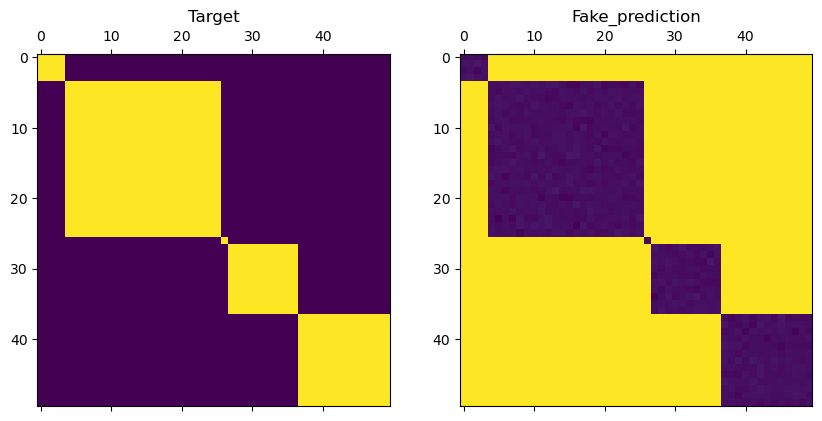

In [9]:
from matplotlib import pyplot as plt
sequence = tf.cast(t[0], tf.float32)
sequence = sequence[tf.newaxis,...]
target = t[1].numpy()
# target[20:25] = np.nan
# target[:, 20:25] = np.nan
target = tf.cast(target, tf.float32)

fake_prediction = np.random.normal(loc=50, scale=100,size=(50, 50))
mask = (target == 0)
fake_prediction[mask] = 9999

f, axes = plt.subplots(1, 2)
axes[0].matshow(target)
axes[0].title.set_text('Target')
axes[1].matshow(fake_prediction)
axes[1].title.set_text('Fake_prediction')
f.set_size_inches(10, 5)

In [10]:
loss_object1 = tf.keras.losses.MeanSquaredError()

print('unmasked loss: ', loss_object1(target, fake_prediction).numpy())
print('masked loss: ', loss_object1(target[~mask], fake_prediction[~mask]).numpy())

unmasked loss:  69190227.3526252
masked loss:  13203.443588376193


In [ ]:
# ./akita_train.py -k -o /home1/yxiao977/sc1/akita_dinoflagellate/real_data/1m/train_out_unmask_gpu_batch8 /home1/yxiao977/sc1/akita_dinoflagellate/real_data/params_dinof_unmask_gpu.json /home1/yxiao977/sc1/akita_dinoflagellate/real_data/1m/
# ./akita_train.py -k -o /home1/yxiao977/sc1/akita_dinoflagellate/test_mask/1m/train_out_unmask_gpu_interpo_batch8_tttttt /home1/yxiao977/sc1/akita_dinoflagellate/test_mask/1m/params_dinof_unmask_gpu.json /home1/yxiao977/sc1/akita_dinoflagellate/test_mask/1m/
